0. 环境配置与模型加载

In [3]:
import sys
sys.path.append('/home/nebula/xxy/3D_Reconstruction')

In [4]:
import os
from pathlib import Path
import math

import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from tools.extract_dinov2_features import DINOv2FeatureExtractor, preprocess_image

# 路径配置：单张输入图像、本地 DINOv2 权重、特征与可视化输出目录
IMG_PATH = Path('/home/nebula/xxy/dataset/2D/scene0000_00/color/200.jpg')  # 修改为你要可视化的图片
FEAT_SAVE_DIR = Path('/home/nebula/xxy/3D_Reconstruction/vis_demo')
LOCAL_DINO_CKPT = Path('/home/nebula/xxy/dataset/models/dinov2_vitl14_reg4_pretrain.pth')
PATCH_SIZE = 14  # DINOv2 ViT-14 patch 大小

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 使用本地权重加载 DINOv2（与离线提取脚本一致）
extractor = DINOv2FeatureExtractor(
    arch='dinov2_vitl14',
    device=str(device),
    dtype=torch.float32,
    checkpoint=str(LOCAL_DINO_CKPT),
)
model = extractor.model
model.eval()
model.to(device)

def pca_color_from_nxc(x: torch.Tensor,
                       brightness: float = 1.2,
                       center: bool = True) -> torch.Tensor:
    """Concerto 风格 PCA 颜色映射：N×C 特征 -> N×3 颜色 (0~1)。"""
    x = x.float()
    x = F.normalize(x, dim=1)
    C = x.shape[1]
    q = min(6, C)
    U, S, V = torch.pca_lowrank(x, center=center, q=q, niter=5)  # V: [C,q]
    proj = x @ V  # [N, q]
    if q >= 6:
        color = proj[:, :3] * 0.6 + proj[:, 3:6] * 0.4
    elif q >= 3:
        color = proj[:, :3]
    else:
        pad = torch.zeros(x.shape[0], 3 - q, device=x.device, dtype=x.dtype)
        color = torch.cat([proj, pad], dim=1)
    min_val, _ = color.min(dim=0, keepdim=True)
    max_val, _ = color.max(dim=0, keepdim=True)
    div = torch.clamp(max_val - min_val, min=1e-6)
    color = (color - min_val) / div * brightness
    color = color.clamp(0.0, 1.0)
    return color


SyntaxError: unexpected character after line continuation character (extract_dinov2_features.py, line 163)

1. 对单张图像提取 DINOv2 特征（不 resize，只 pad），并保存特征

In [ ]:
FEAT_SAVE_DIR.mkdir(parents=True, exist_ok=True)

images = []      # 保存原始图像（PIL）
feats_chw = []   # 保存特征 (C, H_p, W_p)

# 加载图像
img = Image.open(IMG_PATH).convert('RGB')
images.append(img)
W_orig, H_orig = img.size
print(f'Original image size (W,H): {W_orig}, {H_orig}')

# 仅做归一化 + pad，不做 resize
img_tensor = preprocess_image(img, strict=False, patch_size=PATCH_SIZE)  # (3, H_pad, W_pad)
_, H_pad, W_pad = img_tensor.shape
print(f'After preprocess tensor shape: (3, {H_pad}, {W_pad})')
print(f'H_pad % PATCH_SIZE = {H_pad % PATCH_SIZE}, W_pad % PATCH_SIZE = {W_pad % PATCH_SIZE}')

img_tensor = img_tensor.unsqueeze(0).to(device)
img_tensor = img_tensor.to(dtype=model.patch_embed.proj.weight.dtype)

# 前向获取 patch token
with torch.no_grad():
    feats = model.forward_features(img_tensor)

if isinstance(feats, dict):
    if 'x_norm_patchtokens' in feats:
        tokens = feats['x_norm_patchtokens']
    elif 'x_prenorm' in feats:
        tokens = feats['x_prenorm']
    else:
        raise RuntimeError('forward_features dict has no patch token key')
    h_feat = feats.get('h', None)
    w_feat = feats.get('w', None)
else:
    tokens = feats
    h_feat, w_feat = None, None

B, L, C = tokens.shape
print(f'tokens shape: B={B}, L={L}, C={C}, h_feat={h_feat}, w_feat={w_feat}')

# h,w 优先使用模型返回；否则根据 pad 后尺寸推算
if h_feat is None or w_feat is None:
    h = H_pad // PATCH_SIZE
    w = W_pad // PATCH_SIZE
    print(f'Use H_pad/W_pad to compute h,w: h={h}, w={w}, h*w={h*w}')
else:
    h = int(h_feat)
    w = int(w_feat)
    print(f'Use model-reported h,w: h={h}, w={w}, h*w={h*w}')

if h * w > L:
    print(f'[WARN] h*w={h*w} > L={L}, fallback to sqrt(L) grid')
    hw = int(math.sqrt(L))
    h = w = hw
    print(f'fallback h=w={h}, h*w={h*w}')

# 构建 (C, H_p, W_p) 特征图
tokens_hw = tokens[0, : h * w, :]                 # (h*w, C)
feat = tokens_hw.transpose(0, 1).reshape(C, h, w).contiguous()  # (C, H_p, W_p)
feats_chw.append(feat.cpu())

out_feat_path = FEAT_SAVE_DIR / f'{IMG_PATH.stem}_dinov2_feat.pt'
torch.save(feat.cpu(), out_feat_path)
print(f'saved feature to {out_feat_path}, feat shape={tuple(feat.shape)}')


Original image size (W,H): 640, 480
After preprocess tensor shape: (3, 490, 644)
H_pad % PATCH_SIZE = 0, W_pad % PATCH_SIZE = 0
tokens shape: B=1, L=1610, C=1024, h_feat=None, w_feat=None
Use H_pad/W_pad to compute h,w: h=35, w=46, h*w=1610
saved feature to /home/nebula/xxy/3D_Reconstruction/vis_demo/200_dinov2_feat.pt, feat shape=(1024, 35, 46)


2. PCA 可视化（Concerto 风格），上采样回原图大小

feat_chw shape: C=1024, H_p=35, W_p=46, H_p*W_p=1610
upsampled PCA shape: H_up=490, W_up=644
cropped PCA shape: (480, 640, 3)


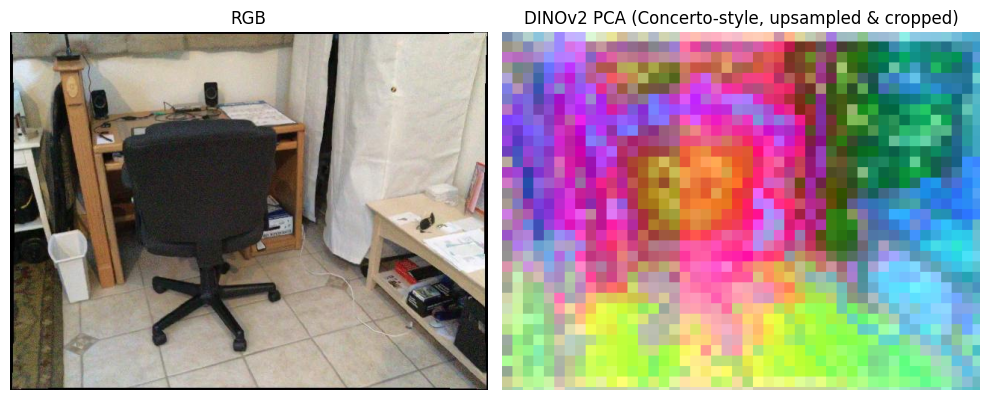

In [ ]:
def imshow_rgb(img, title=None):
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0.0, 1.0)
    elif isinstance(img, Image.Image):
        img = np.array(img) / 255.0
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# 展示第 1 张原图和对应的 DINOv2 PCA 伪彩色
if len(images) > 0 and len(feats_chw) > 0:
    feat = feats_chw[0]  # (C, H_p, W_p)
    C, H_p, W_p = feat.shape
    print(f'feat_chw shape: C={C}, H_p={H_p}, W_p={W_p}, H_p*W_p={H_p*W_p}')
    x = feat.reshape(C, -1).T  # [N, C]
    color = pca_color_from_nxc(x)
    img_pca_patch = color.view(H_p, W_p, 3).cpu().numpy()
    img_pca_patch = np.clip(img_pca_patch, 0.0, 1.0)

    # 将 patch 网格上采样回 pad 后尺寸，再裁剪回原始尺寸
    img_pca_up = np.kron(img_pca_patch, np.ones((PATCH_SIZE, PATCH_SIZE, 1), dtype=img_pca_patch.dtype))
    H_up, W_up, _ = img_pca_up.shape
    print(f'upsampled PCA shape: H_up={H_up}, W_up={W_up}')
    img_pca_crop = img_pca_up[:H_orig, :W_orig, :]
    print(f'cropped PCA shape: {img_pca_crop.shape}')

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    imshow_rgb(images[0], title='RGB')
    plt.subplot(1, 2, 2)
    plt.imshow(img_pca_crop)
    plt.title('DINOv2 PCA (Concerto-style, upsampled & cropped)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('No image or feature to visualize')


3. 保存 PCA 伪彩色图到磁盘（与显示逻辑一致）

In [ ]:
if len(images) > 0 and len(feats_chw) > 0:
    feat = feats_chw[0]
    C, H_p, W_p = feat.shape
    x = feat.reshape(C, -1).T
    color = pca_color_from_nxc(x)
    img_pca_patch = color.view(H_p, W_p, 3).cpu().numpy()
    img_pca_patch = np.clip(img_pca_patch, 0.0, 1.0)
    img_pca_up = np.kron(img_pca_patch, np.ones((PATCH_SIZE, PATCH_SIZE, 1), dtype=img_pca_patch.dtype))
    img_pca_crop = img_pca_up[:H_orig, :W_orig, :]
    out_png = FEAT_SAVE_DIR / f'{IMG_PATH.stem}_dinov2_pca.png'
    plt.imsave(out_png, img_pca_crop)
    print(f'saved PCA image to {out_png}, shape={img_pca_crop.shape}')
else:
    print('No image or feature, skip saving')


saved PCA image to /home/nebula/xxy/3D_Reconstruction/vis_demo/200_dinov2_pca.png, shape=(480, 640, 3)
